**Goal:** To Predict aqueous Solubility (logS) of small molecules based on their molecular structure using Machine Learning

- "Solubility prediction remains a criticial challenge due to the lack of reliable and reproducible measurements alongside the time and cost of experimental approaches. A machine learning (ML) algorithm that accurately describes behavioral component compositions can be used to fulfill this requirement."
- (reference: DOI:10.1186/s13321-023-00752-6)

**1. Importing libraries**

 - Each library has a specific role to play: data handling, machine learning modelling, chemical feature creation, model evaluation

 - 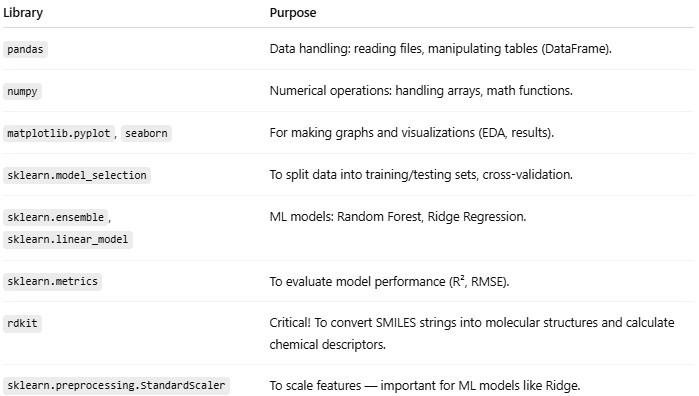

In [1]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 52.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.preprocessing import StandardScaler, LabelEncoder


**2. Loading the dataset**

In [3]:
df = pd.read_csv('delaney-processed.csv')
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


**3. Feature Extraction**

In [4]:
# converting SMILES string into chemical descriptors

def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
      return None

    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),

    }
    return descriptors

In [5]:
# applying the descriptor calculation to each SMILES and creathing a new dataframe

descriptors_df = df['smiles'].apply(calculate_descriptors).apply(pd.Series)
descriptors_df.head()

,MolWt,TPSA,LogP,NumHAcceptors,NumHDonors,NumAromaticRings,NumRotatableBonds
0,457.432,202.32,-3.10802,12.0,7.0,1.0,7.0
1,201.225,42.24,2.84032,2.0,1.0,2.0,2.0
2,152.237,17.07,2.87800,1.0,0.0,0.0,4.0
3,278.354,0.00,6.29940,0.0,0.0,5.0,0.0
4,84.143,0.00,1.74810,1.0,0.0,1.0,0.0


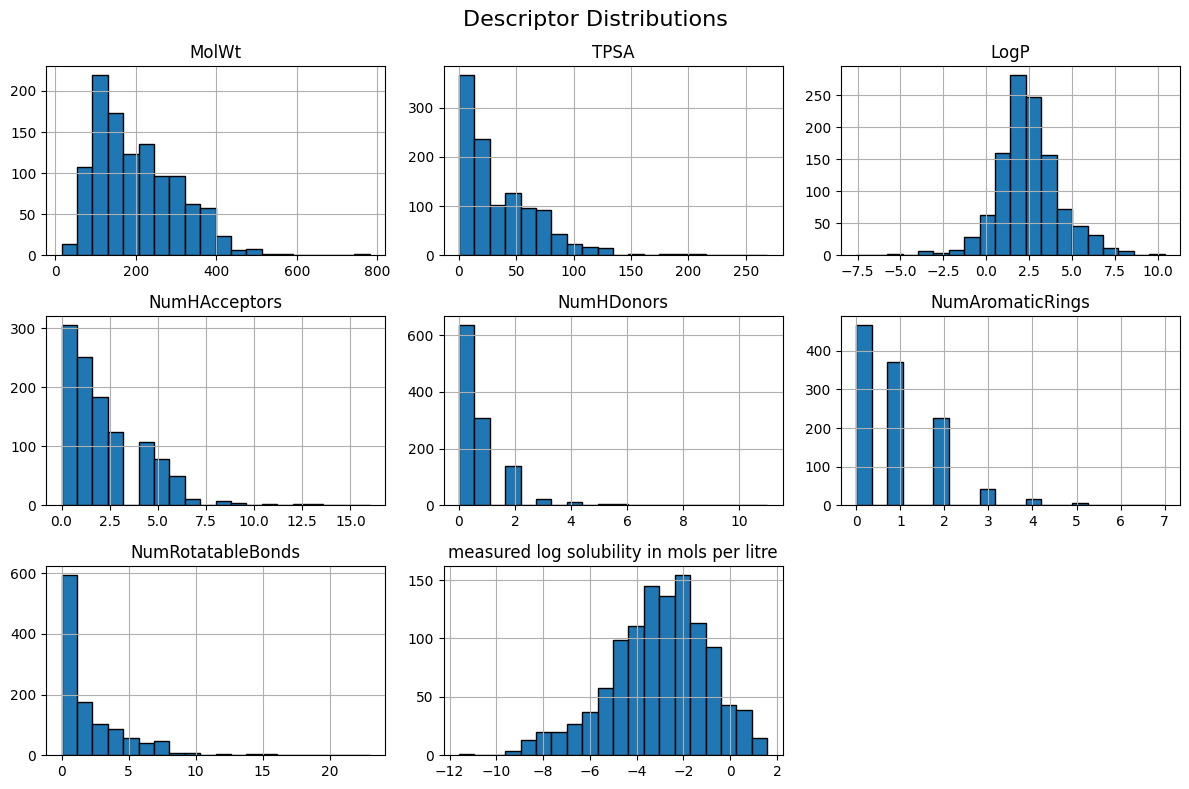

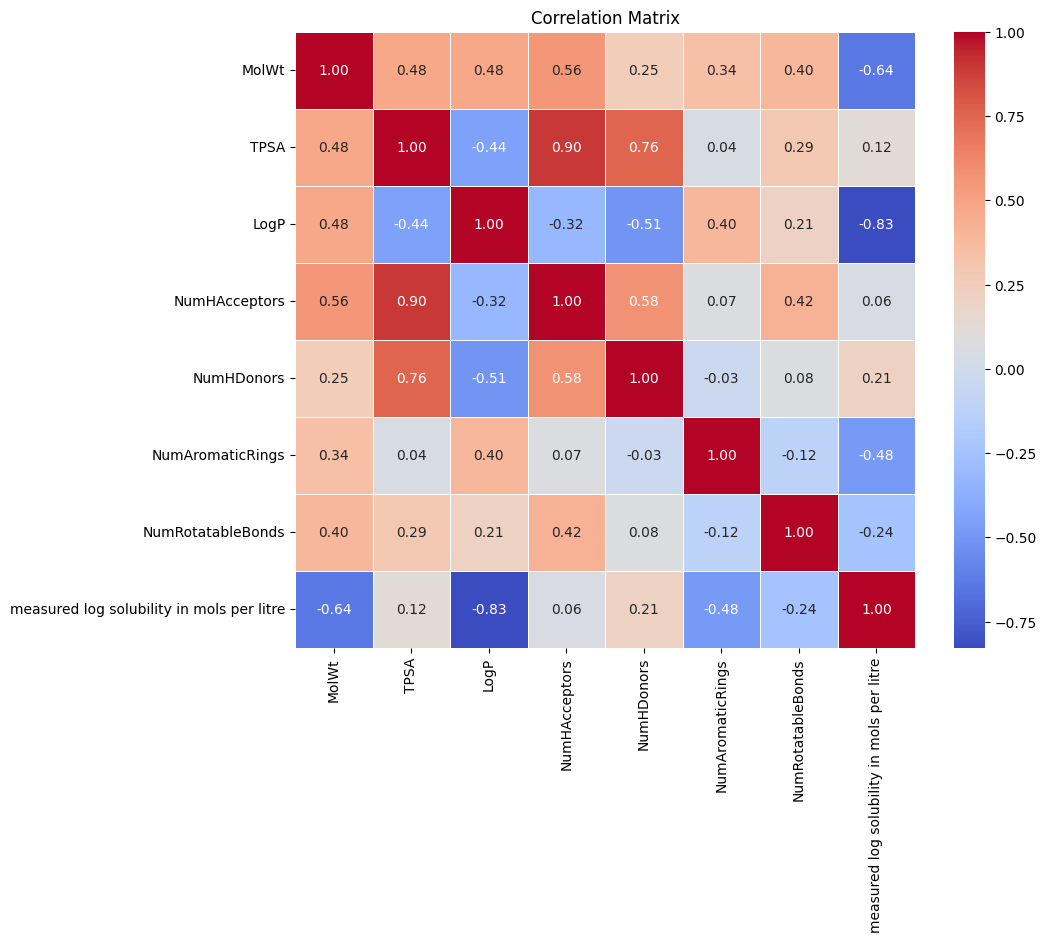

In [6]:
# Merge descriptors with target column
df = pd.concat([descriptors_df, df['measured log solubility in mols per litre']], axis=1)

# Histogram of all descriptors
df.hist(bins=20, figsize=(12, 8), edgecolor='black')
plt.suptitle("Descriptor Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



**Outlier Treatment**

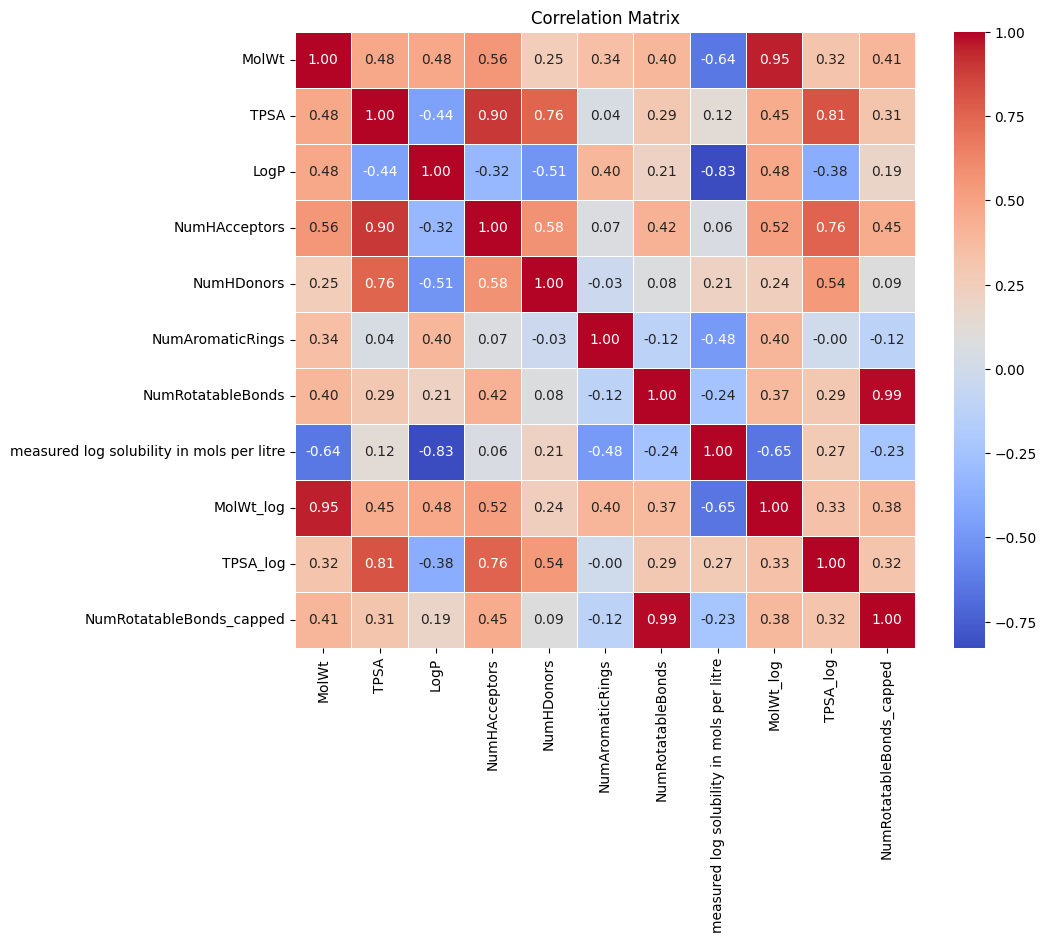

In [ ]:
# Apply log transform to skewed descriptors
df['MolWt_log'] = np.log1p(df['MolWt'])
df['TPSA_log'] = np.log1p(df['TPSA'])

# Cap NumRotatableBonds at 99th percentile
cap = df['NumRotatableBonds'].quantile(0.99)
df['NumRotatableBonds_capped'] = np.where(df['NumRotatableBonds'] > cap, cap, df['NumRotatableBonds'])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


**4. Splitting**

In [ ]:
x = descriptors_df
y = df['measured log solubility in mols per litre']  # keep as float (no LabelEncoder)

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


**5. Train + Compare models**


Linear Regression
R² Score: 0.7650
RMSE: 1.0539
MAE: 0.7870

Ridge Regression
R² Score: 0.7651
RMSE: 1.0538
MAE: 0.7869

Random Forest
R² Score: 0.8593
RMSE: 0.8156
MAE: 0.5563

Gradient Boosting
R² Score: 0.8626
RMSE: 0.8058
MAE: 0.5768


<ipython-input-46-dabf830518cd>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R2', palette='viridis')


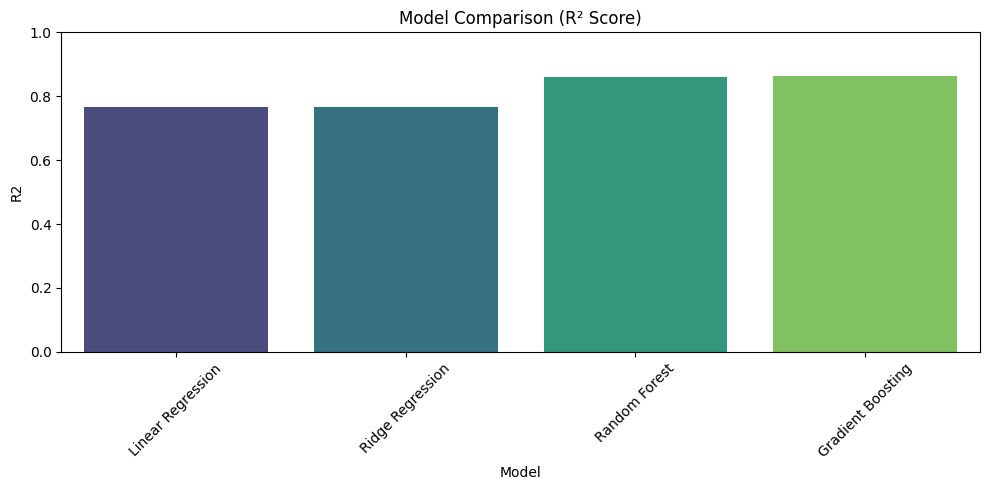

In [ ]:
# Define all the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append((name, r2, rmse, mae))

    print(f"\n{name}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE', 'MAE'])

# Plot R² comparison
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x='Model', y='R2', palette='viridis')
plt.title("Model Comparison (R² Score)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Result :** Gradient Boosting Regressor is the best model here because ->
                highest R², lowest RMSE values

**6. Residual Analysis for Gradient Boosting**
*  done to check how well the predictions follow the actual values

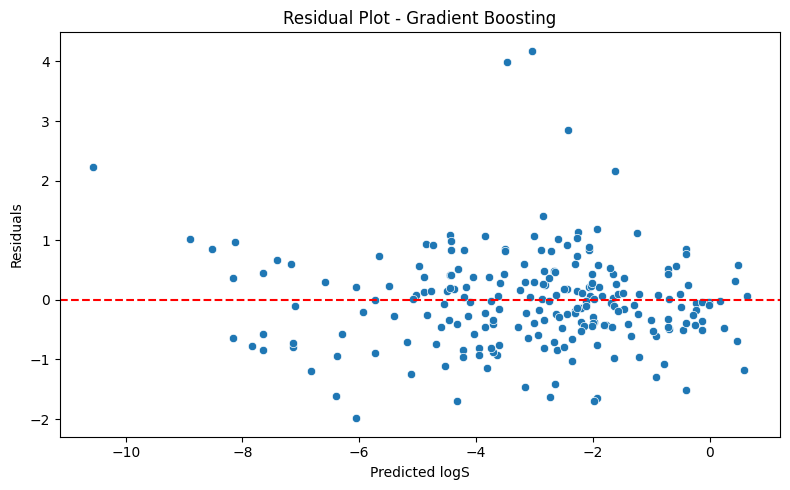

In [ ]:
# Residual plot for Gradient Boosting
best_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted logS")
plt.ylabel("Residuals")
plt.title("Residual Plot - Gradient Boosting")
plt.tight_layout()
plt.show()


Higher LogP often correlates with lower aqueous solubility due to increased hydrophobicity. Similarly, high TPSA (polar surface area) usually indicates good solubility. These chemical insights validate the feature selection process.
